# WIDS 2024 - Developing a Facial Recognition System using Siamese Neural Networks

Name: Arijit Mandal
<br>
Roll: 23B0961

## 1. Importing dependences

In [ ]:
import cv2                          # OpenCV for facial recognition
import os                           # Operating system library
import uuid                         # Unique identifier for images
import matplotlib.pyplot as plt     # Plotting results

# Functional API - Tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

## 2. Set Environment Variables

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 3. Set up the data folder structure


In [ ]:
pos_path = os.path.join('data', 'positive')
neg_path = os.path.join('data', 'negative')
anchor_path = os.path.join('data', 'anchor')

# Make the directories
os.makedirs(pos_path, exist_ok = True)
os.makedirs(neg_path, exist_ok = True)
os.makedirs(anchor_path, exist_ok = True)

## 4. Extract Labelled Faces in the Wild dataset

In [ ]:
# Source: http://vis-www.cs.umass.edu/lfw/
# Download the tar file and untar it
!tar -xf lfw.tgz

# Move the LFW images into the "negative" directory
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw', directory)):
    old_path = os.path.join('lfw', directory, file)
    new_path = os.path.join(neg_path, file)
    os.replace(old_path, new_path)

# Remove "lfw" directory with all its subdirectories
!rm -r lfw


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


## 5. Collect positive and anchor images from webcam

In [ ]:
# Establish connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()

  # Frame should be 250x250 px
  frame = frame[120:120+250, 200:200+250, :]

  # Collect anchor images when key 'A' is pressed
  if(cv2.waitKey(1) & 0XFF == ord('a')):
    imgname = os.path.join(anchor_path, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Collect positive images when key 'P' is pressed
  if(cv2.waitKey(1) & 0XFF == ord('p')):
    imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Display image on screen
  cv2.imshow('Image Collection', frame)

  # Break when key "Q" is pressed
  if(cv2.waitKey(1) & 0XFF == ord('q')):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

## 6. Collect all images from each directory

In [ ]:
anchor = tf.data.Dataset.list_files(anchor_path + '/*.jpg').take(400)
positive = tf.data.Dataset.list_files(pos_path + '/*.jpg').take(400)
negative = tf.data.Dataset.list_files(neg_path + '/*.jpg').take(400)

## 7. Preprocess the data - Scale and Resize

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))
    img = img/255.0
    return img

## 8. Create Labelled Dataset

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

## 9. Prepare train and test partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Training partition
train_data = data.take(round(len(data) * 0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data) * 0.8))
test_data = test_data.take(round(len(data) * 0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## 10. Build Embedding Layer for the model

In [ ]:
def make_embedding():
    input = Input(shape=(105, 105, 3))

    # First Layer
    x = Conv2D(64, (10, 10), activation='relu')(input)
    x = MaxPooling2D(64, (2,2), padding='same')(x)

    # Second Layer
    x = Conv2D(128, (7, 7), activation='relu')(x)
    x = MaxPooling2D(64, (2,2), padding='same')(x)

    # Third Layer
    x = Conv2D(128, (4, 4), activation='relu')(x)
    x = MaxPooling2D(64, (2,2), padding='same')(x)

    # Fourth Layer
    x = Conv2D(256, (4, 4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)

    return Model(inputs = input, outputs = x, name = 'Embedding')

## 11. Build Distance Layer for the model

In [ ]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 12. Build Siamese Model

In [ ]:
def make_siamese_model():
    input_image = Input(name = 'input_img', shape = (105,105,3))
    validation_image = Input(name = 'validation_img', shape = (105,105,3))

    # Embedding layer
    embedding = make_embedding()
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)

    # Distance layer
    distance_layer = L1Dist()
    distance_layer._name = 'distance'
    distances = distance_layer(input_embedding, validation_embedding)

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 105, 105, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 105, 105, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist (L1Dist)          │ (None, 4096)           │              0 │ Embedding[0][0],       │
│                           │                        │                │ Embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ l1_dist[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## 13. Training the model

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok = True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 14. Training step function

In [ ]:
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:

        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

## 15. Training Loop

In [ ]:
def train(data, EPOCHS):

    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)

        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

train(train_data, 50)


 Epoch 1/50
tf.Tensor(0.6934142, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
 1/40 ━━━━━━━━━━━━━━━━━━━━ 5:16 8s/steptf.Tensor(0.673362, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
 2/40 ━━━━━━━━━━━━━━━━━━━━ 31s 829ms/steptf.Tensor(0.6705543, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
 3/40 ━━━━━━━━━━━━━━━━━━━━ 28s 772ms/steptf.Tensor(0.6291778, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
 4/40 ━━━━━━━━━━━━━━━━━━━━ 28s 793ms/steptf.Tensor(0.54693604, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
 5/40 ━━━━━━━━━━━━━━━━━━━━ 28s 801ms/steptf.Tensor(0.42912257, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
 6/40 ━━━━━━━━━━━━━━━━━━━━ 26s 784ms/steptf.Tensor(0.4698067, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
 7/40 ━━━━━━━━━━━━━━━━━━━━ 25s 774ms/steptf.Tensor(0.4326633, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
 8/40 ━━━━━━━━━━━━━━━━━━

## 16. Evaluate the model

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1.0 1.0


## 17. Visualize Results

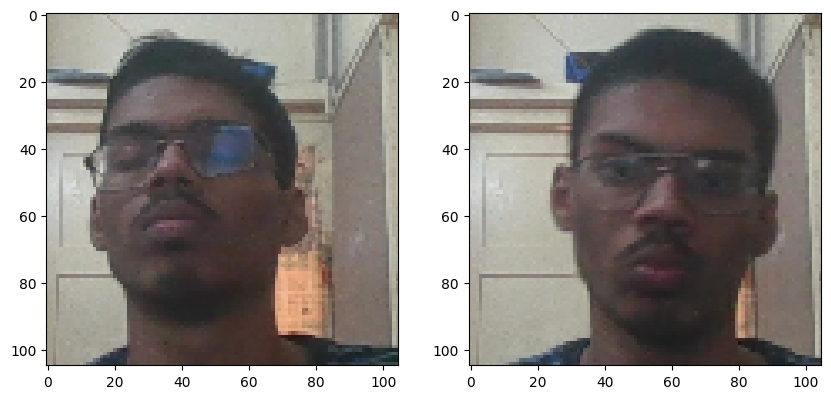

In [ ]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()